In [1]:
import nest_asyncio
nest_asyncio.apply()

from hddCRP.modelBuilder import cdCRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator
from sklearn.metrics import roc_auc_score

from pandas.api.types import CategoricalDtype
import os

In [2]:
session_numbers = [1]; # index by 1

overwrite_existing_results = False
results_directory = "Results/population/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

subjects = ["uniform", "diverse"]
subjects.sort()
print("subjects = " + str(subjects))

context_depth = 1;
nback_depth = 1;

action_labels = [0,1,2]

subjects = ['diverse', 'uniform']


In [3]:
start_session = np.min(session_numbers)
end_session = np.max(session_numbers)
fit_file = f"{results_directory}/fits_session_{start_session}"
fit_summary_file = f"{results_directory}/fit_summary_session_{start_session}"
if(end_session != start_session):
    fit_file += f"_to_{start_session}"
    fit_summary_file  += f"_to_{start_session}"

if(nback_depth != 1 or context_depth != 2):
    fit_file += f"_cd{context_depth}_nb{nback_depth}"
    fit_summary_file  += f"_cd{context_depth}_nb{nback_depth}"

fit_file += f".pkl"
fit_summary_file += f".pkl"

if(not os.path.isfile(fit_file) or overwrite_existing_results):
    data_fits = pd.DataFrame()
    data_fit_metrics = pd.DataFrame()
    for subject_index, subject in enumerate(subjects):
        print(f"subject {subject} ")

        sequences = []
        session_types = []
        subject_labels = []
        for subject_p in data["group_definition"][subject]:
            sequences_0 = data["data"][subject_p]["data"]; # turns in each session
            session_types_0 = data["data"][subject_p]["task"] # which maze
            ii = list(np.where(np.array(session_types_0)=='C')[0][np.array(session_numbers)-1])
            sequences     += [sequences_0[xx] for xx in ii]
            session_types += [session_types_0[xx] for xx in ii]
            subject_labels += [subject_p] * len(ii)

        stan_seed = (subject_index+1) * 1000 + start_session

        model = cdCRP(sequences, session_labels=session_types, subject_labels=subject_labels, possible_observations=action_labels);
        model.same_nback_depth = nback_depth
        model.context_depth = context_depth


        model.build(random_seed=stan_seed);
        model.fit_model()

        map_fit = model.get_map()
        fit_df  = model.fit.to_frame()

        fit_df["subject"] = subject
        fit_df["start_session_C"] = start_session
        fit_df["end_session_C"] = end_session
        summary_df = model.fit_summary()
        summary_df["subject"] = subject
        summary_df["MAP"] = pd.Series(map_fit)
        summary_df["start_session_C"] = start_session
        summary_df["end_session_C"] = end_session

        data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
        data_fits = pd.concat([data_fits,fit_df], copy=False)

    data_fits.to_pickle(fit_file)
    data_fit_metrics.to_pickle(fit_summary_file)
else:
    print("fit file found")



fit file found


In [4]:
parameter_name_map = {"alpha" : "concentration", 
                      "context_similarity_depth_1" : "context weight level 1",
                      "context_similarity_depth_2" : "context weight level 2", 
                      "repeat_bias_1_back" : "repeat bias",
                      "timeconstant_within_session_A" : "time constant",
                      "timeconstant_within_session_C" : "time constant"}

ss = "session_1_cd1_nb1";
summary_df = pd.read_pickle("Results/population/fit_summary_" + ss + ".pkl")
summary_df.index.name = "parameter"
summary_df = summary_df.reset_index()
summary_df["parameter"] = summary_df["parameter"].map(parameter_name_map)
data_fits  = pd.read_pickle("Results/population/fits_" + ss + ".pkl")
data_fits.rename(columns=parameter_name_map, inplace=True)

params = list(summary_df["parameter"].unique());



concentration: p(diverse > uniform) = 0.6672943124999999
time constant: p(diverse > uniform) = 0.867925125
repeat bias: p(diverse > uniform) = 0.0929529375
context weight level 1: p(diverse > uniform) = 0.9352765624999999


/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


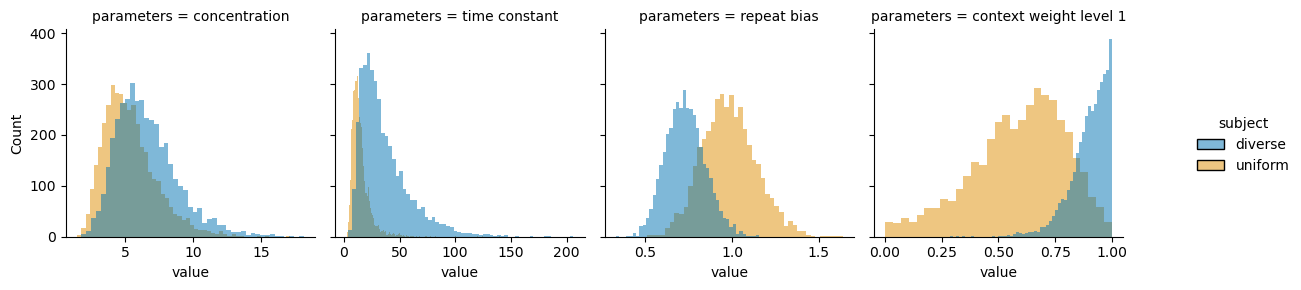

In [15]:
pval_seed = 10;
sim_rng = np.random.Generator(np.random.MT19937(pval_seed))

pval = np.zeros((len(params)))
for ii, param in enumerate(params):
    #fit.hist(params[ii], by="subject", ax=ax);
    cat_type = CategoricalDtype(categories=["uniform", "diverse"], ordered=True)
    df_c = data_fits[["subject", param]]
    df_c = df_c.assign(subject_c= df_c["subject"].astype(cat_type))
    df_c['subject_c'].replace(['uniform', 'diverse'],
                            [0, 1], inplace=True)
    pval[ii] = roc_auc_score(df_c['subject_c'].to_numpy(), df_c[param].to_numpy())

    print(f"{param}: p(diverse > uniform) = {pval[ii]}")


df_c2 = data_fits.melt(value_vars=params, id_vars=["subject"])
df_c2.head()

sns.displot(
    df_c2, x="value", col="parameters", hue="subject", palette="colorblind",
    height=3, facet_kws={"margin_titles": True, "sharex" :False},common_bins=False
)


In [ ]:
fit_df